In [1]:
import pyro
import torch
import wandb
import os

from inference.bayesian.models import TorchModel, HorseshoeSSVS
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [512, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "inference": "ssvs",
            "num_samples": 1500,
            "num_chains": 2,
            "plot": False,
            "sweep": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Run ESN on dataset and produce embeddings with or without dimensionality reduction according to `dim_reduction`

In [4]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding, diffXte, diffYte = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 10428, Val: 5214, Te: 5214


# Stochastic Search Variable Selection


Perform SSVS on embeddings with no dimensionality reduction.

In [5]:
# Define the horseshoe SSVS model
ssvs_model = HorseshoeSSVS(activation='tanh', device=device)

# pyro.render_model(ssvs_model, model_args=(train_embedding[0], Ytr[0]), render_distributions=True, filename=None)

In [6]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [7]:
# Run Markov chains and collect diagnostics
predictive, diagnostics = inference(config, ssvs_model, None,
                                    X_train=train_embedding, Y_train=Ytr,
                                    X_val=val_embedding, Y_val=Yval, 
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

Sample: 100%|██████████| 1500/1500 [00:26, 56.69it/s, step size=1.56e-02, acc. prob=0.019]


Checking convergence...
Chain 0 completed.
Chain 1 completed.
MCMC converged at 0 steps.


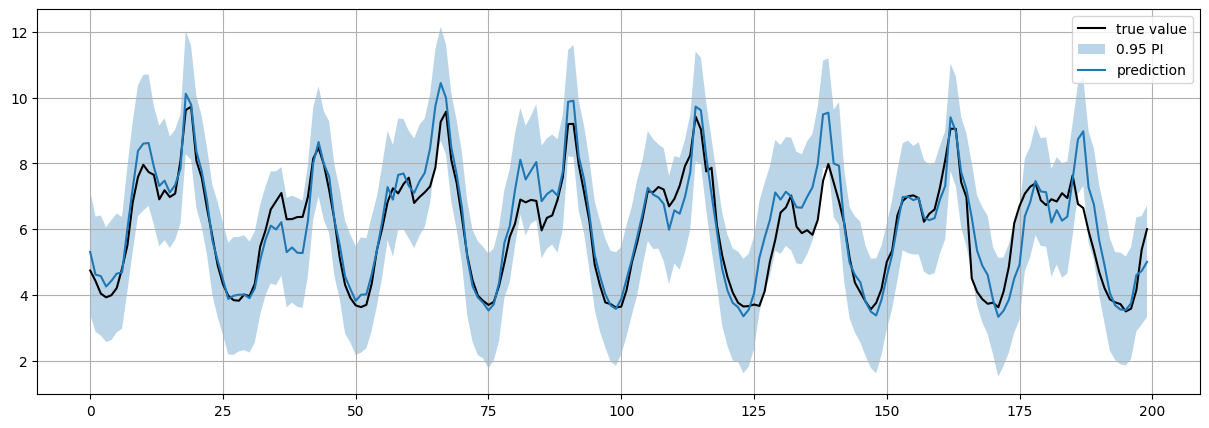

In [8]:
plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), "ssvs")

In [7]:
import pyro.distributions as dist

In [13]:
gs = []
ts = []
for n in range(500):
    tau = pyro.sample("tau", dist.HalfCauchy(1.))
    ts.append(1/(1+tau**2))
    lamb = pyro.sample("lamb", dist.HalfCauchy(1.))
    sig = lamb*tau
    gamma = pyro.sample("gamma", dist.Normal(0, sig))
    gs.append(gamma)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1., 492.,   5.,   1.]),
 array([-4132.63525391, -3602.16040039, -3071.68530273, -2541.21044922,
        -2010.73547363, -1480.26049805,  -949.78564453,  -419.31066895,
          111.16426086,   641.63922119,  1172.11413574]),
 <BarContainer object of 10 artists>)

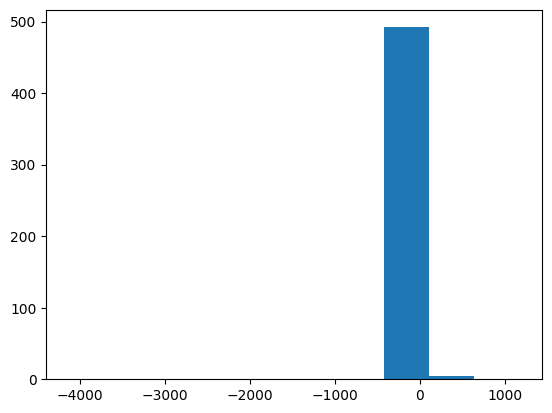

In [14]:
import matplotlib.pyplot as plt

plt.hist(gs)

(array([2.32000221, 1.00000088, 0.76000072, 0.76000072, 0.70000067,
        0.72000069, 0.54000051, 0.78000074, 0.80000076, 1.62000154]),
 array([9.48623153e-07, 1.00000851e-01, 2.00000763e-01, 3.00000668e-01,
        4.00000572e-01, 5.00000477e-01, 6.00000381e-01, 7.00000286e-01,
        8.00000191e-01, 9.00000095e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

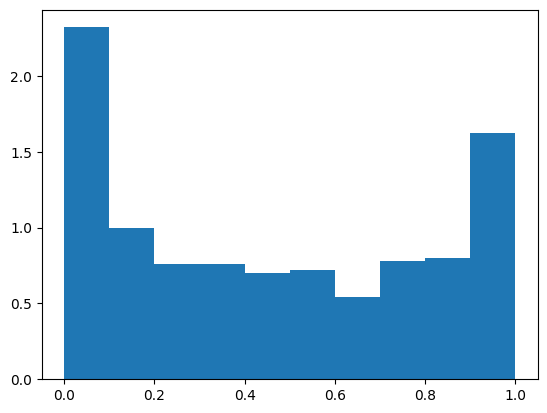

In [16]:
plt.hist(ts, density=True)

In [8]:
for k, v in diagnostics.items():
    print(k)

step_size
acceptance_rate
train_time
effective_sample_size
split_gelman_rubin
autocorrelation
quantiles
cal_error
crps


In [11]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])

training time:  65.39963948299997
calibration error:  0.4393422258594366
Continuous ranked probability score:  0.3246365666767971


In [21]:
# to reload a package or method
import sys, importlib

importlib.reload(sys.modules['bayesian.utils'])

from inference.bayesian.utils import plot_forecast

In [23]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')